<a href="https://colab.research.google.com/github/seanreed1111/colab-demos/blob/master/pymc_marketing_cdnow_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.brucehardie.com/datasets/

In [1]:
%pip install pymc-marketing arviz -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 482.7/482.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.4 MB/s eta 0:00:00


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arviz.labels import MapLabeller

from pymc_marketing import clv
az.style.use("arviz-darkgrid")

%config InlineBackend.figure_format = "retina" # nice looking plots

https://www.pymc-marketing.io/en/stable/notebooks/clv/clv_quickstart.html

The file CDNOW_master.txt contains the entire purchase history up to the end of June 1998 of the cohort of 23,570 individuals who made their first-ever purchase at CDNOW in the first quarter of 1997. This CDNOW dataset was first used by Fader and Hardie (2001).

Each record in this file, 69,659 in total, comprises four fields: the customer's ID, the date of the transaction, the number of CDs purchased, and the dollar value of the transaction.
(this is the sample only)

In [ ]:
raw_trans = pd.read_csv("https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/cdnow_transactions.csv")

In [5]:
raw_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6919 entries, 0 to 6918
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   _id         6919 non-null   int64  
 1   id          6919 non-null   int64  
 2   date        6919 non-null   int64  
 3   cds_bought  6919 non-null   int64  
 4   spent       6919 non-null   float64
dtypes: float64(1), int64(4)
memory usage: 270.4 KB


In [15]:
mask = raw_trans["id"] == 6
mask

0       False
1       False
2       False
3       False
4       False
        ...  
6914    False
6915    False
6916    False
6917    False
6918    False
Name: id, Length: 6919, dtype: bool

In [16]:
raw_trans[mask]

,_id,id,date,cds_bought,spent
9,111,6,19970101,1,35.99
10,111,6,19970111,1,32.99
11,111,6,19970315,4,77.96
12,111,6,19970416,3,59.30
13,111,6,19970424,2,134.98
14,111,6,19970623,1,91.92
15,111,6,19970722,3,47.08
16,111,6,19970726,2,71.96
17,111,6,19971025,3,78.47
18,111,6,19971206,3,83.47


1.1 Data Requirements
For all models, the following nomenclature is used:

`customer_id` represents a unique identifier for each customer.

`frequency` represents the number of repeat purchases that a customer has made, i.e. one less than the total number of purchases.

`T` represents a customer’s “age”, i.e. the duration between a customer’s first purchase and the end of the period of study. In this example notebook, the units of time are in weeks.

`recency` represents the timepoint when a customer made their most recent purchase. This is also equal to the duration between a customer’s first non-repeat purchase (usually time 0) and last purchase. If a customer has made only 1 purchase, their recency is 0;

`monetary_value` represents the average value of a given customer’s repeat purchases. Customers who have only made a single purchase have monetary values of zero.



In [6]:
rfm_data = clv.utils.rfm_summary(
    raw_trans,
    customer_id_col = "id",
    datetime_col = "date",
    monetary_value_col = "spent",
    datetime_format = "%Y%m%d",
    time_unit = "W")

rfm_data.head(25)

,customer_id,frequency,recency,T,monetary_value
0,1,3.0,49.0,78.0,23.723333
1,2,1.0,2.0,78.0,11.770000
2,3,0.0,0.0,78.0,0.000000
3,4,0.0,0.0,78.0,0.000000
4,5,0.0,0.0,78.0,0.000000
5,6,14.0,76.0,78.0,76.503571
6,7,1.0,5.0,78.0,11.770000
7,8,1.0,61.0,78.0,26.760000
8,9,3.0,58.0,78.0,36.190000
9,10,0.0,0.0,78.0,0.000000


In [18]:
# double = pd.concat([raw_trans, raw_trans], axis=0)
# double.info()
# double_rfm_data = clv.utils.rfm_summary(
#     double,
#     customer_id_col = "id",
#     datetime_col = "date",
#     monetary_value_col = "spent",
#     datetime_format = "%Y%m%d",
#     time_unit = "W")

# double_rfm_data.head(25) #it aggregates all transactions on the same date as a single transaction

,customer_id,frequency,recency,T,monetary_value
0,1,3.0,49.0,78.0,47.446667
1,2,1.0,2.0,78.0,23.540000
2,3,0.0,0.0,78.0,0.000000
3,4,0.0,0.0,78.0,0.000000
4,5,0.0,0.0,78.0,0.000000
5,6,14.0,76.0,78.0,153.007143
6,7,1.0,5.0,78.0,23.540000
7,8,1.0,61.0,78.0,53.520000
8,9,3.0,58.0,78.0,72.380000
9,10,0.0,0.0,78.0,0.000000


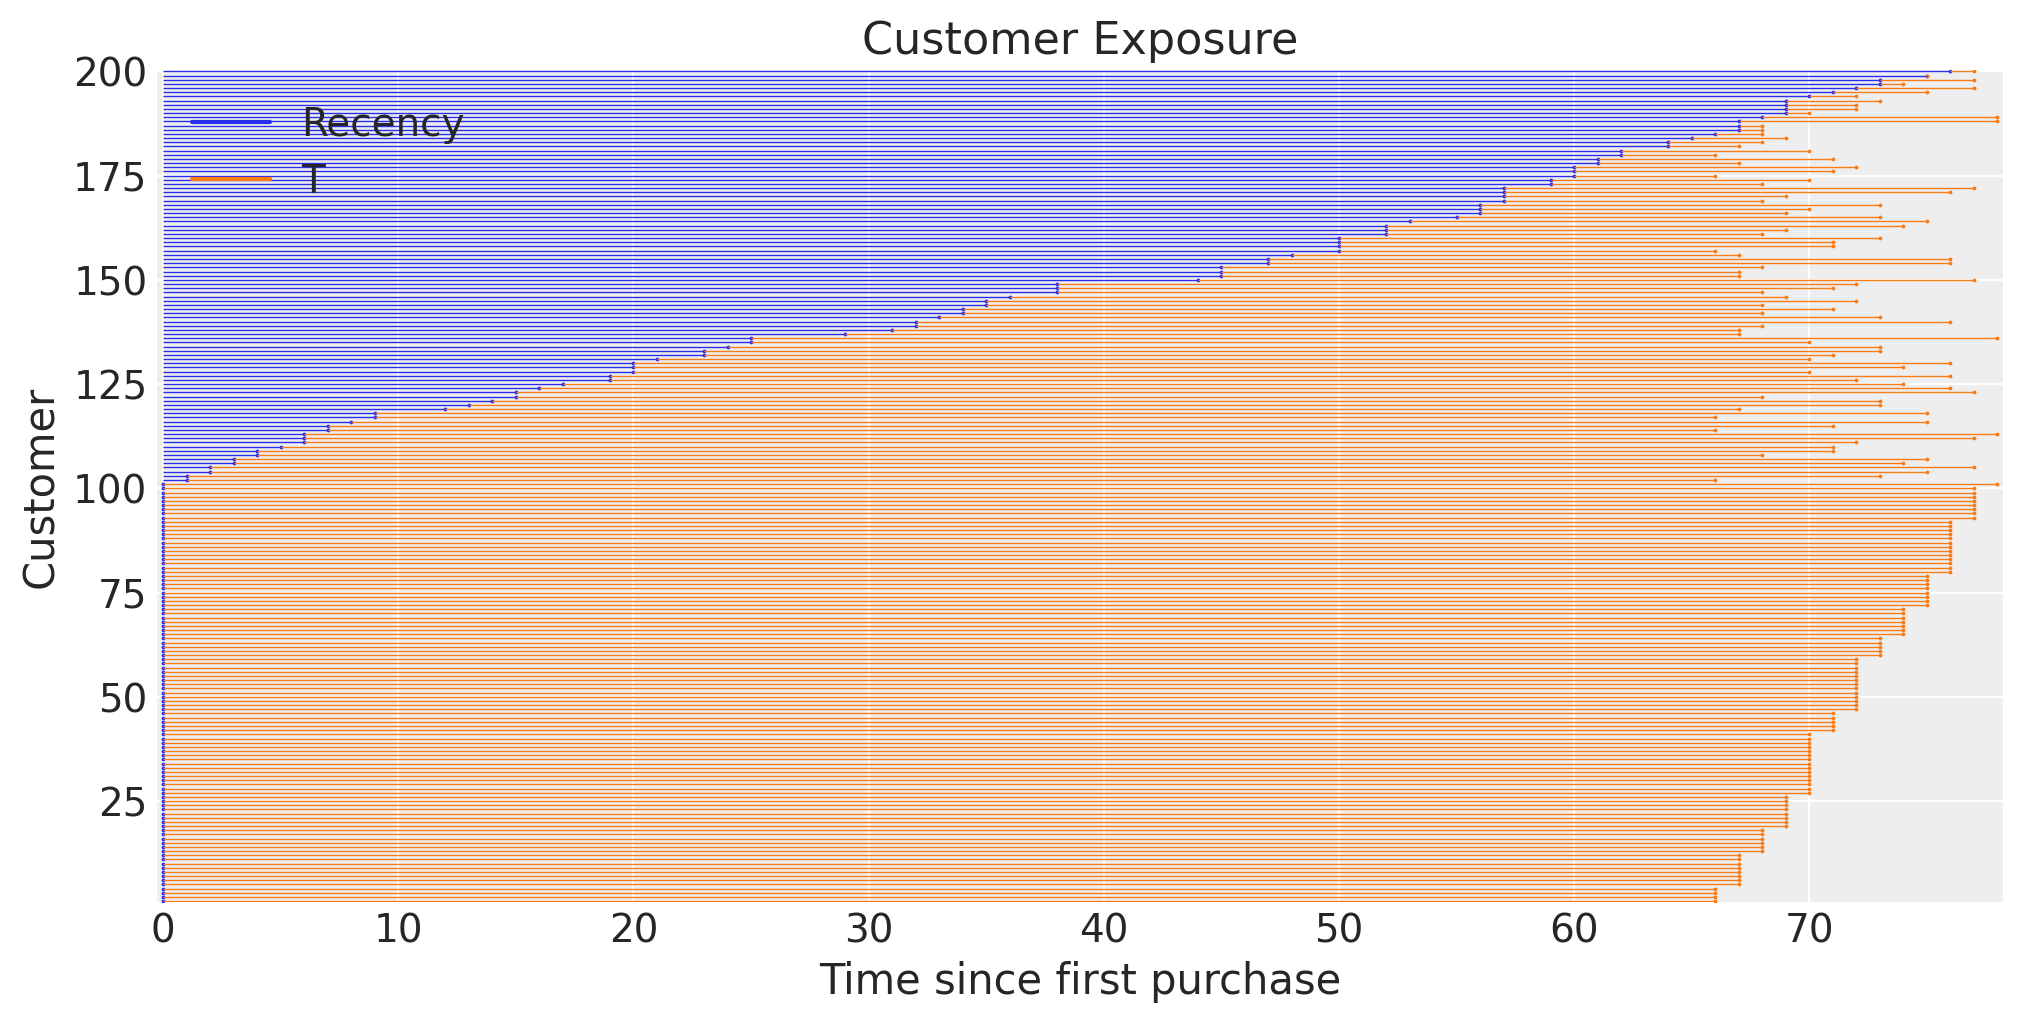

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
(
    rfm_data
    .sample(n=200, random_state=42)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

In [22]:
bgm = clv.BetaGeoModel(
    data = rfm_data
)
bgm.build_model()
bgm

BG/NBD
         a ~ HalfFlat()
         b ~ HalfFlat()
     alpha ~ HalfFlat()
         r ~ HalfFlat()
likelihood ~ Potential(f(r, alpha, b, a))

The default priors for the 4 parameters follow a HalfFlat distribution, which is an improper positive uniform distribution. For small datasets this prior can yield implausible posteriors. To avoid this problem, more informative priors can be specified by defining custom PyMC distributions.

Here, we will replace the HalfFlat default by more well-behaved HalfNormal priors with a standard deviation of 10.

Customization priors is possible by passing a dictionary with keys being the name of the prior, and values being a dictionary with 2 keys:

- ‘dist’ representing the name of PyMC distribution and

- ‘kwargs’ that holds an optional dictionary of all parameters we wish to pass to the distribution

In [23]:
model_config = {
    'a_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'b_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'alpha_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'r_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
}

bgm = clv.BetaGeoModel(
    data = rfm_data,
    model_config = model_config,
)
bgm.build_model()
bgm

BG/NBD
         a ~ HalfNormal(0, 10)
         b ~ HalfNormal(0, 10)
     alpha ~ HalfNormal(0, 10)
         r ~ HalfNormal(0, 10)
likelihood ~ Potential(f(r, alpha, b, a))

In [24]:
bgm.fit()
bgm.fit_summary()

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.685,0.156,0.435,0.990,0.005,0.004,954.0,788.0,1.0
b,3.249,0.973,1.655,5.065,0.033,0.024,978.0,940.0,1.0
alpha,7.113,0.495,6.165,7.993,0.014,0.010,1222.0,1062.0,1.0
r,0.276,0.012,0.254,0.298,0.000,0.000,1231.0,1043.0,1.0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


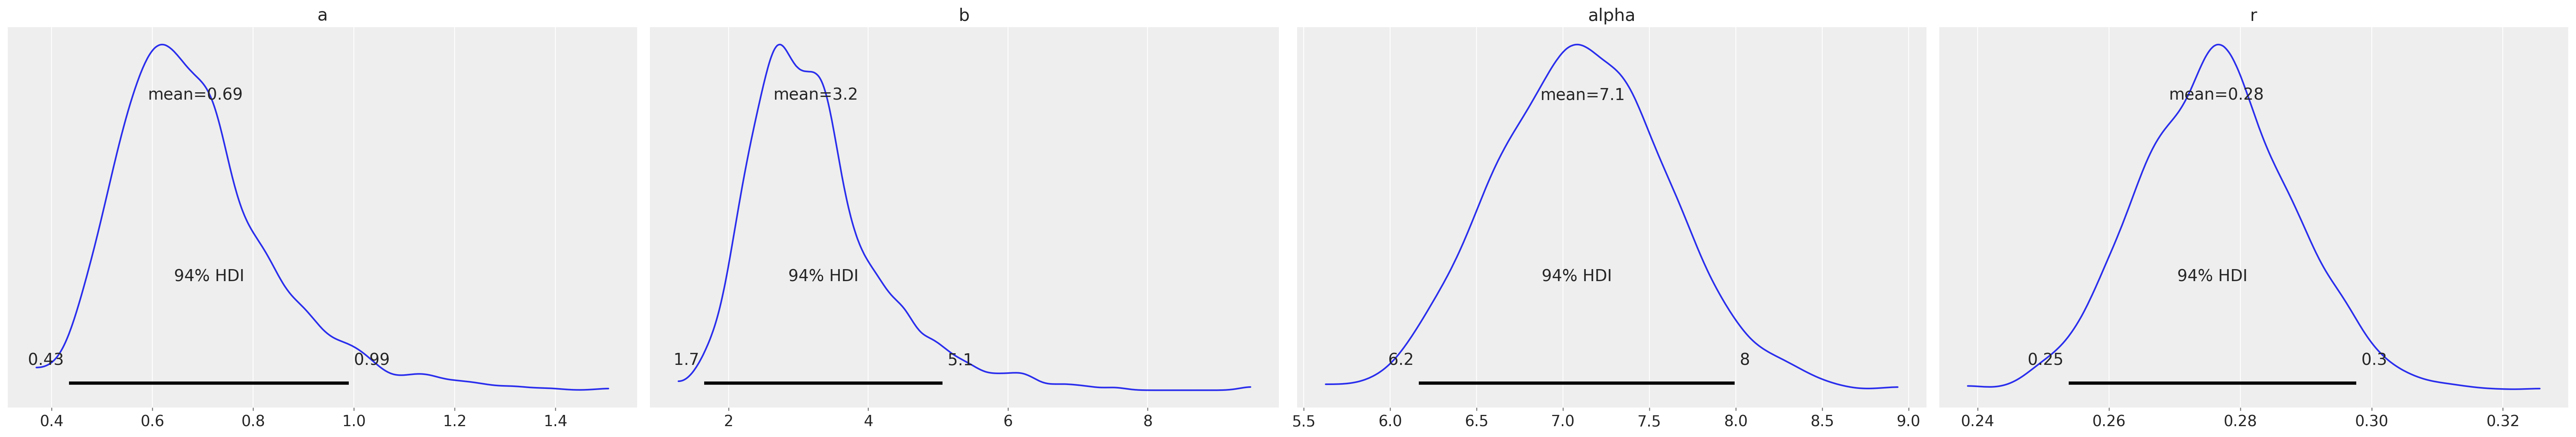

In [25]:
az.plot_posterior(bgm.fit_result);

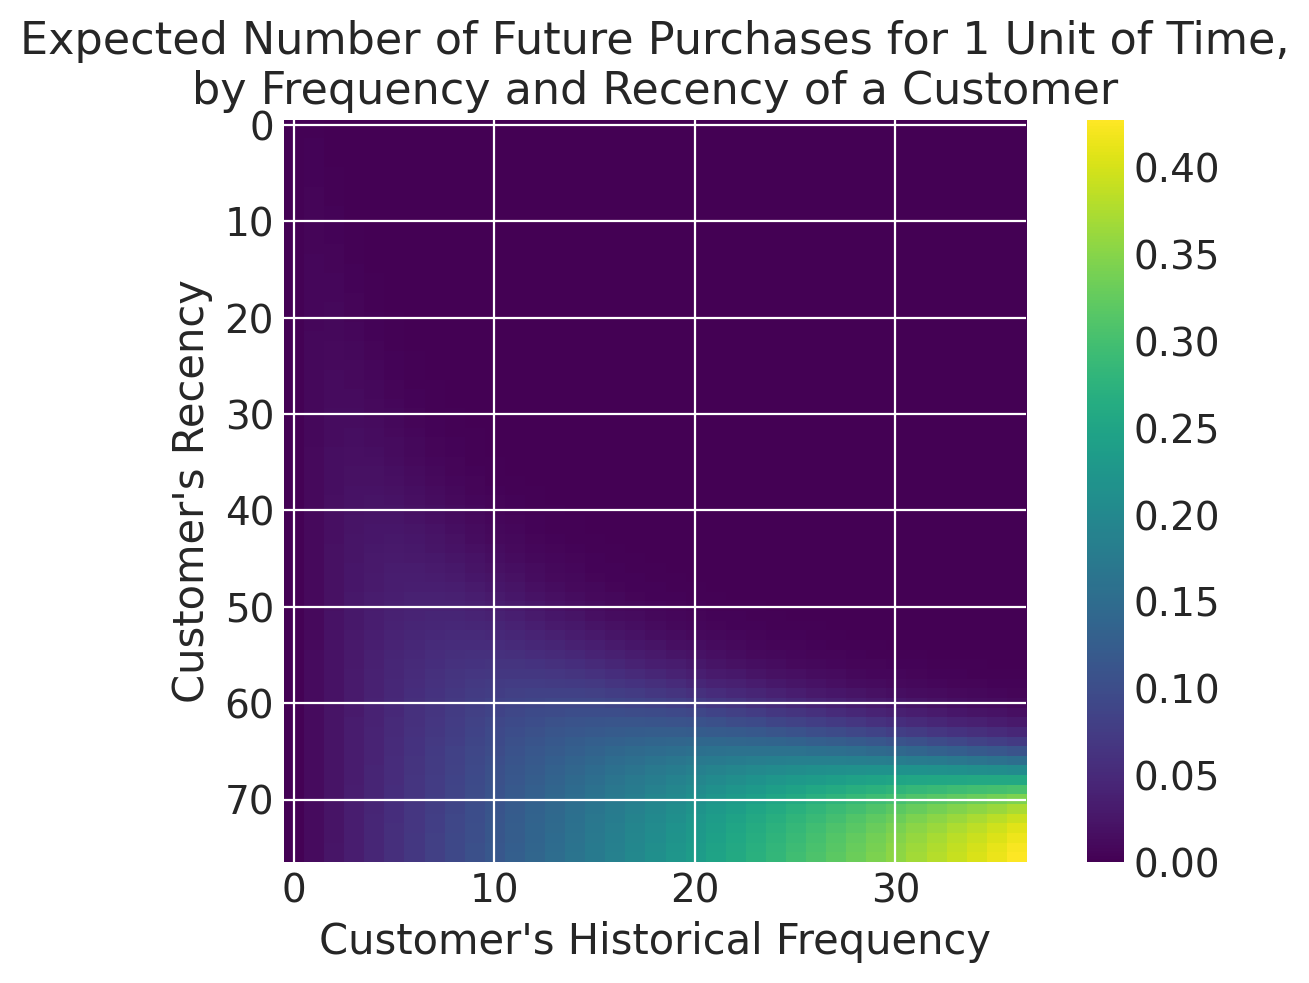

In [26]:
clv.plot_frequency_recency_matrix(bgm);

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

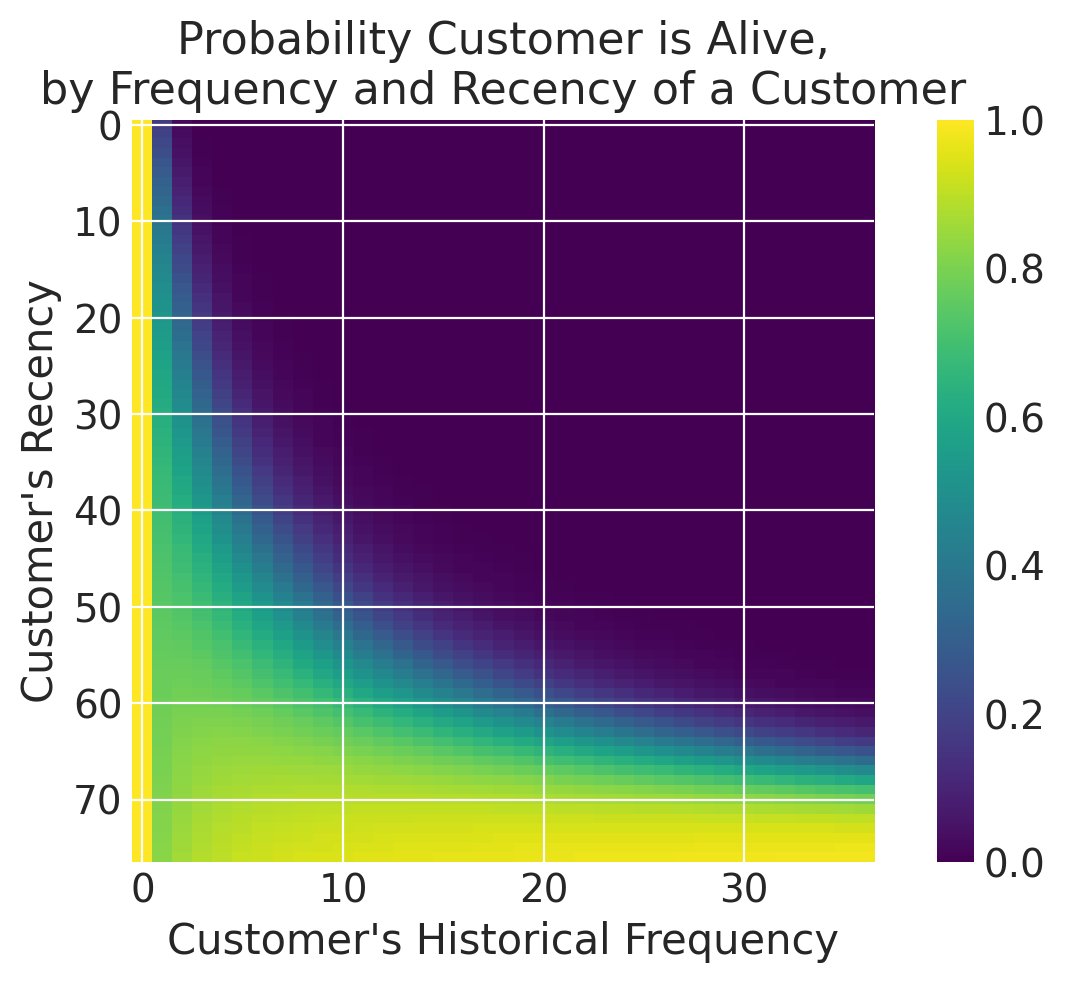

In [27]:
clv.plot_probability_alive_matrix(bgm)

Note that all non-repeat customers have an alive probability of 1, which is one of the quirks of `BetaGeoModel`. In many use cases this is still a valid assumption, but if non-repeat customers are a key focus in your use case, you may want to try `ParetoNBDModel` instead.

## Ranking customers from best to worst
Having fit the model, we can ask what is the expected number of purchases for our customers in the next period.

Let’s look at the four more promising customers.

In [28]:
num_purchases = bgm.expected_num_purchases(
    customer_id=rfm_data["customer_id"],
    t=1, #who will buy in 1 week period
    frequency=rfm_data["frequency"],
    recency=rfm_data["recency"],
    T=rfm_data["T"]
)

In [30]:
num_purchases.head()

<xarray.DataArray (chain: 2, draw: 5, customer_id: 5)>
array([[[0.02567509, 0.00372659, 0.00316596, 0.00316596, 0.00316596],
        [0.02452975, 0.00310841, 0.00328675, 0.00328675, 0.00328675],
        [0.02422477, 0.0029764 , 0.00336964, 0.00336964, 0.00336964],
        [0.02463707, 0.00322394, 0.00329415, 0.00329415, 0.00329415],
        [0.02588528, 0.0038431 , 0.00320511, 0.00320511, 0.00320511]],

       [[0.02540463, 0.00295735, 0.00328508, 0.00328508, 0.00328508],
        [0.02420156, 0.00310153, 0.00319915, 0.00319915, 0.00319915],
        [0.02484461, 0.00282894, 0.00315615, 0.00315615, 0.00315615],
        [0.02517326, 0.00293991, 0.00312207, 0.00312207, 0.00312207],
        [0.02544963, 0.00305053, 0.00311891, 0.00311891, 0.00311891]]])
Coordinates:
  * chain        (chain) int64 0 1
  * draw         (draw) int64 0 1 2 3 4
  * customer_id  (customer_id) int64 1 2 3 4 5

In [32]:
sdata = rfm_data.copy()
sdata["expected_purchases"] = num_purchases.mean(("chain", "draw")).values
top_4 = sdata.sort_values(by="expected_purchases").tail(4)
top_4

,customer_id,frequency,recency,T,monetary_value,expected_purchases
812,813,30.0,72.0,74.0,35.654000,0.355850
1202,1203,32.0,71.0,72.0,47.172187,0.394549
156,157,36.0,74.0,77.0,30.603611,0.402911
1980,1981,35.0,66.0,68.0,46.748857,0.446546


We can plot the uncertainty in the expected number of purchases in the next period.

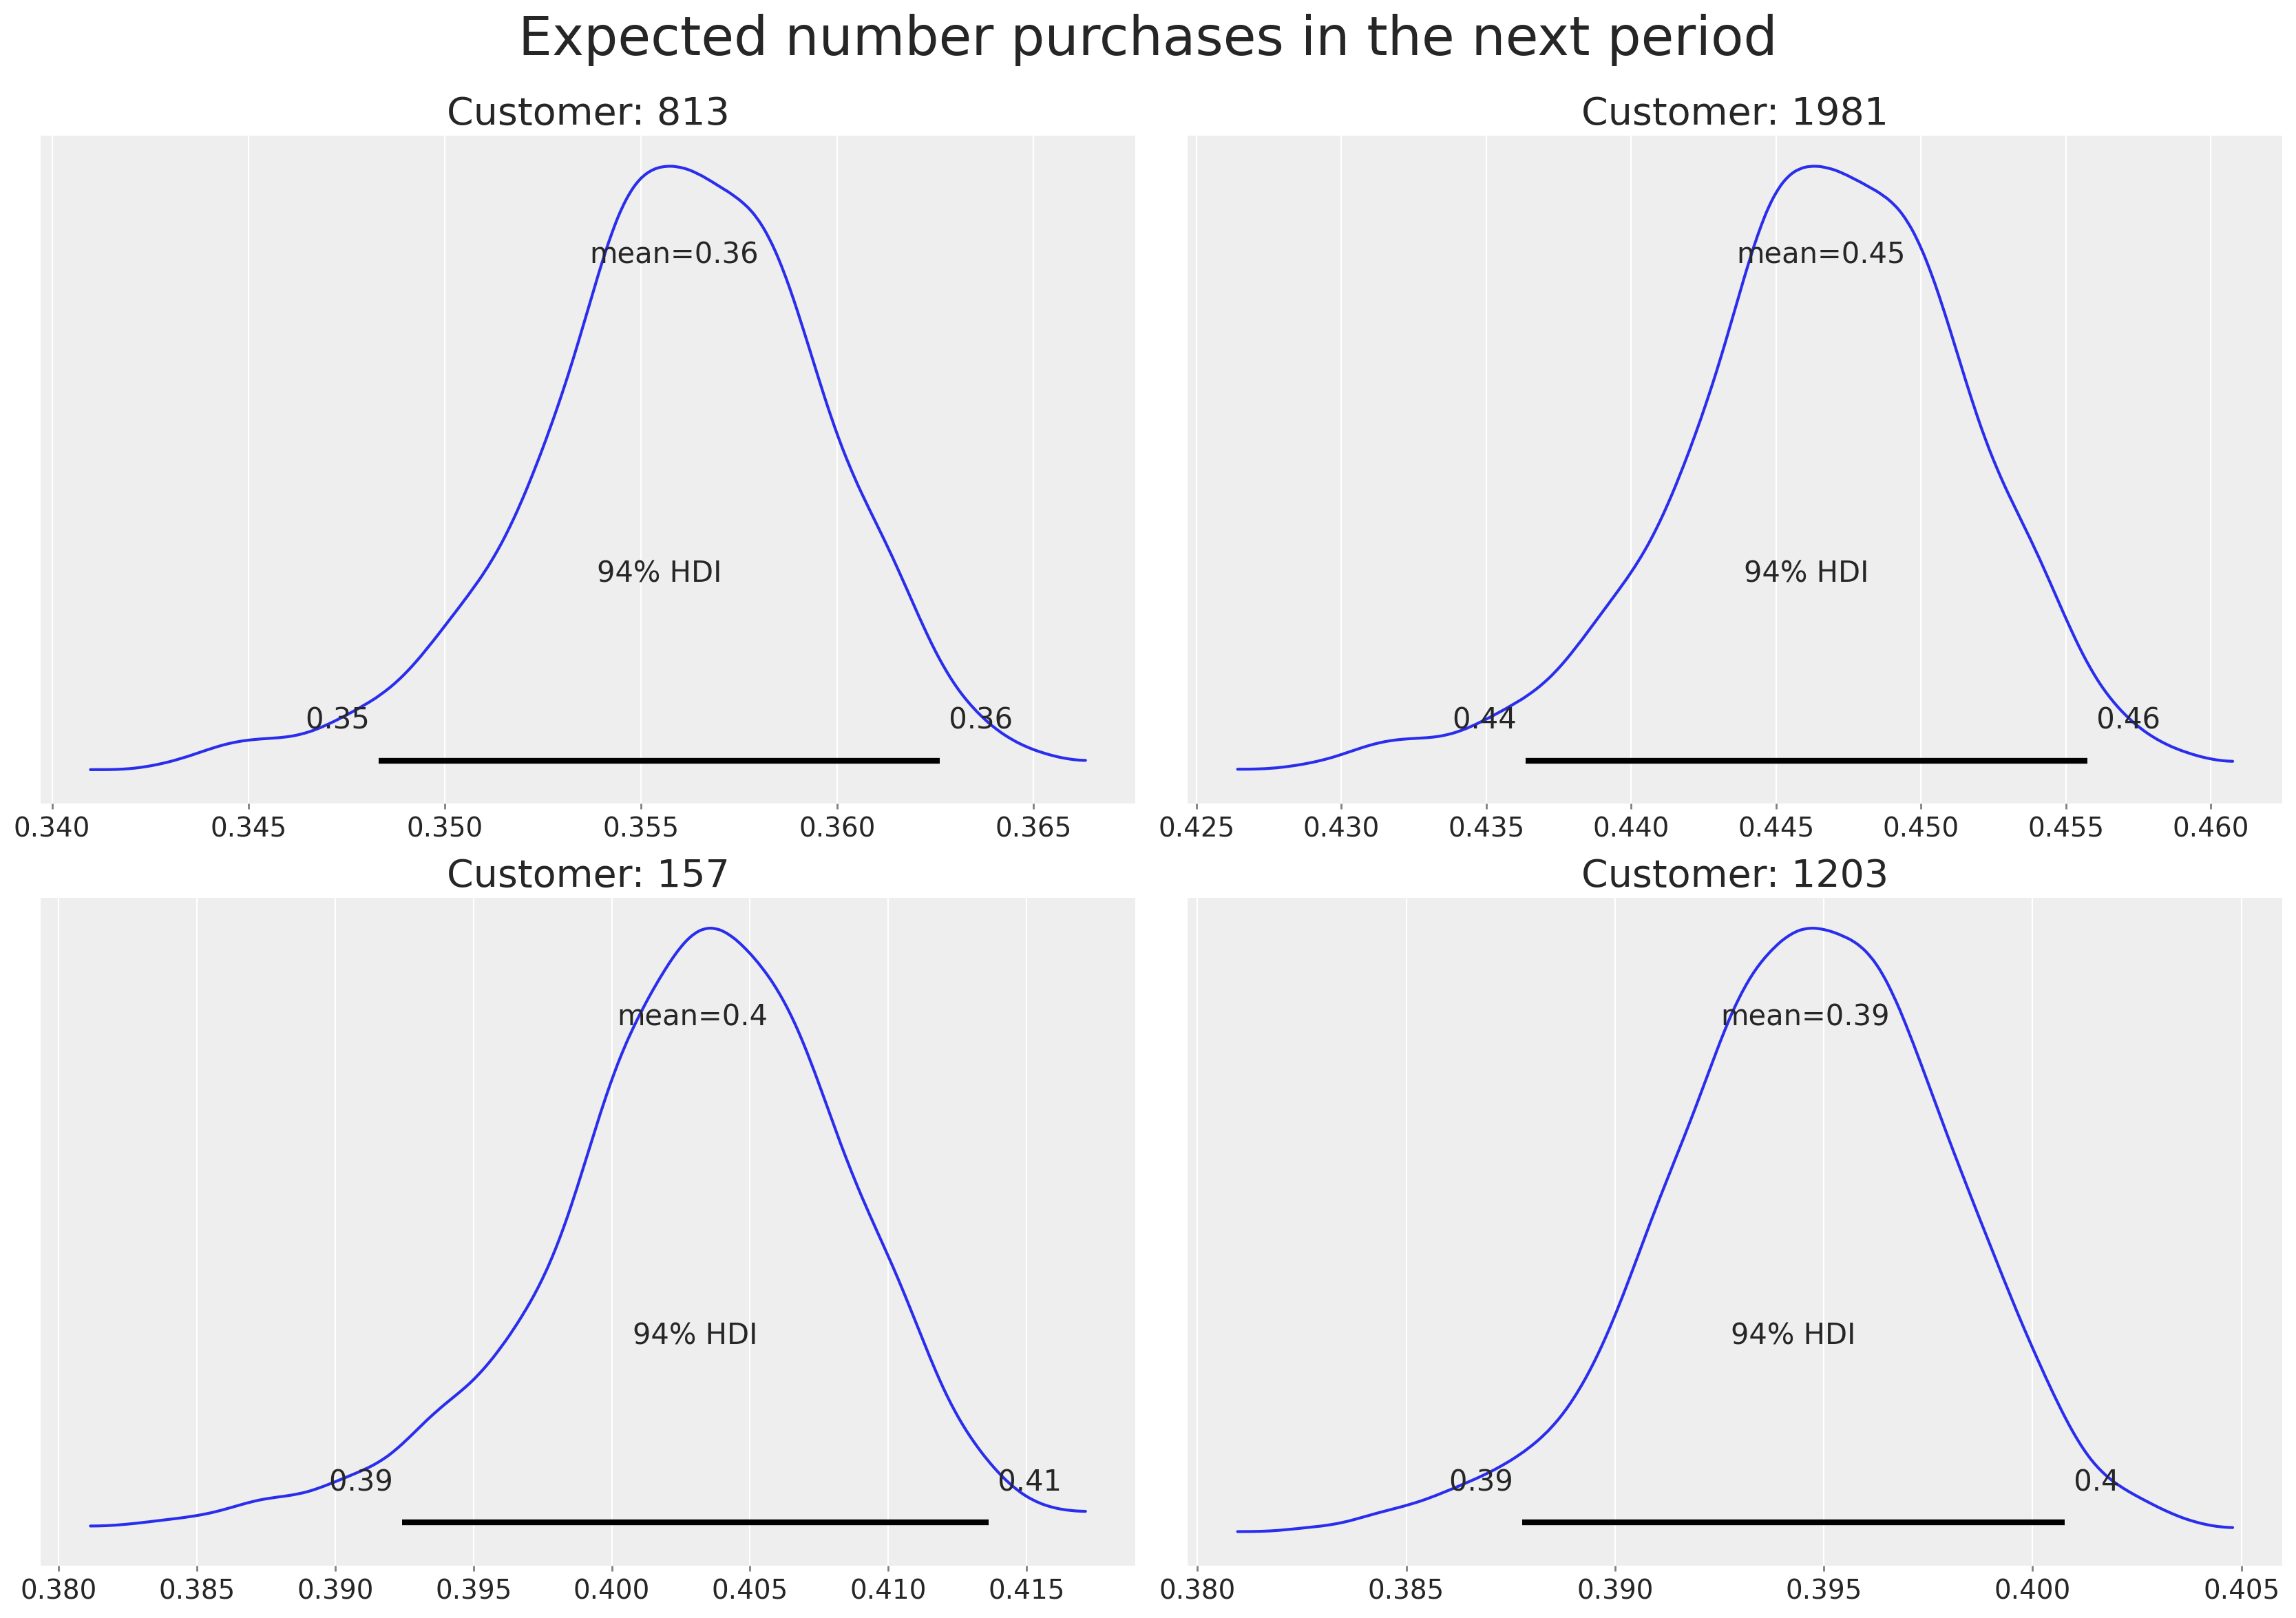

In [31]:
ids = top_4["customer_id"].to_list()
ax = az.plot_posterior(num_purchases.sel(customer_id=ids), grid=(2, 2))
for axi, id in zip(ax.ravel(), ids, strict=False):
    axi.set_title(f"Customer: {id}", size=20)
plt.suptitle("Expected number purchases in the next period", fontsize=28, y=1.05);

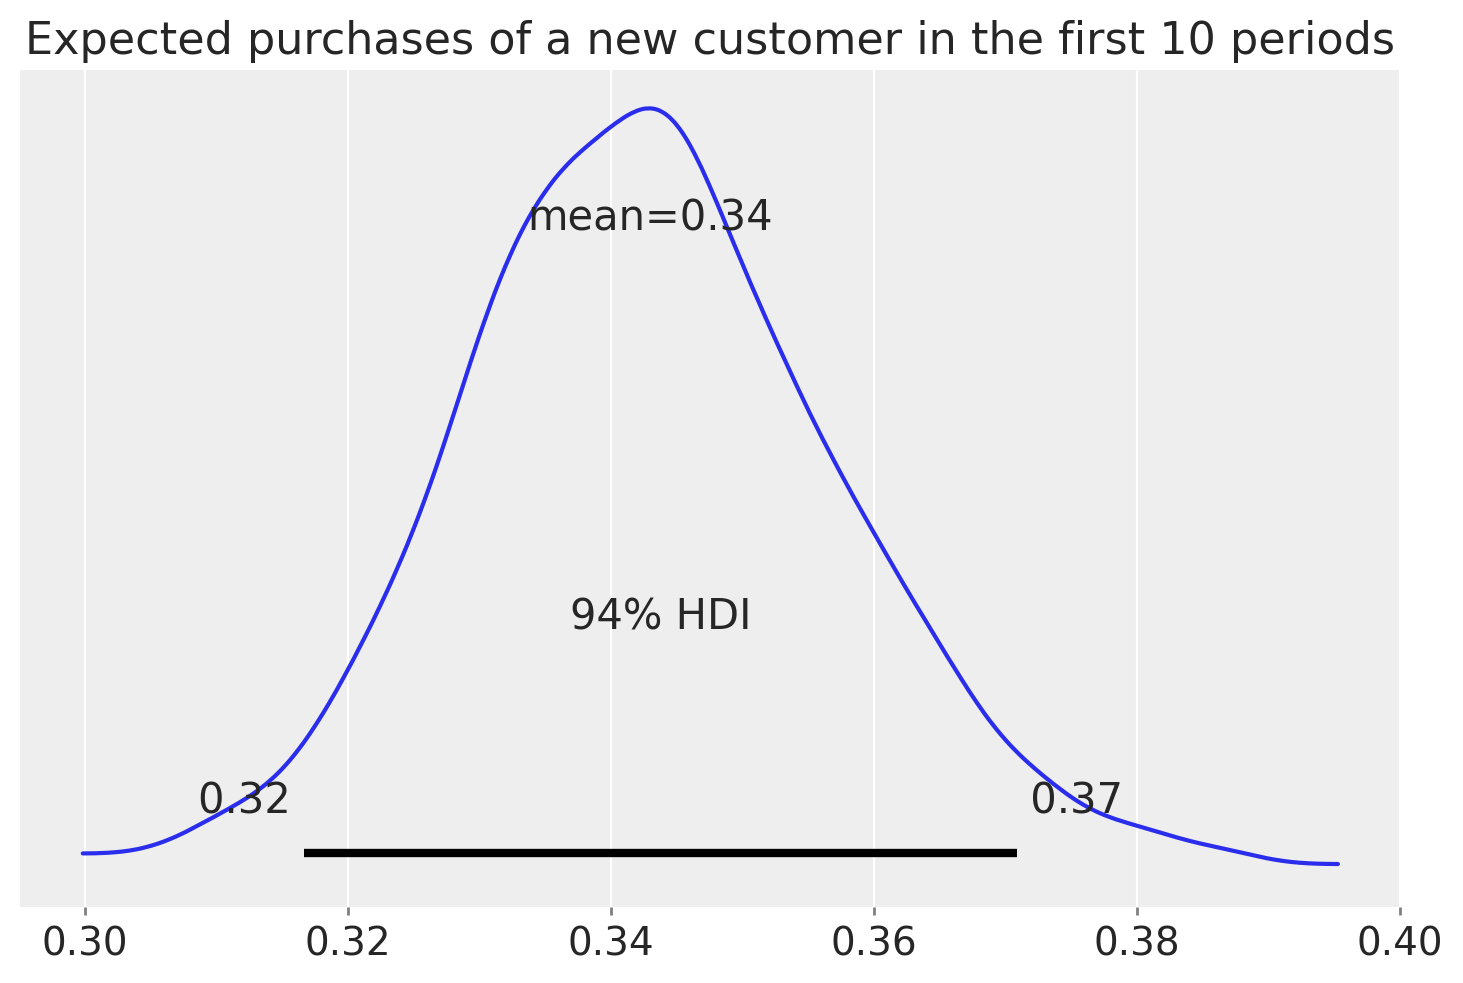

In [35]:
# We can use the fitted model to predict the number of purchases for a fresh new customer.
az.plot_posterior(
    bgm.expected_num_purchases_new_customer(t=10)
)
plt.title("Expected purchases of a new customer in the first 10 periods");

In [37]:
# Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model.

#Let look at active customer 1516 and assess the change in probability that the user will ever return if they do no other purchases in the next 9 time periods.
customer_1516 = rfm_data.loc[1515]
customer_1516_history = pd.DataFrame(dict(
    ID=np.full(10, 1515, dtype="int"),
    frequency=np.full(10, customer_1516["frequency"], dtype="int"),
    recency=np.full(10, customer_1516["recency"]),
    T=(np.arange(0, 10) + customer_1516["recency"]).astype("int"),

))
customer_1516_history


,ID,frequency,recency,T
0,1515,27,67.0,67
1,1515,27,67.0,68
2,1515,27,67.0,69
3,1515,27,67.0,70
4,1515,27,67.0,71
5,1515,27,67.0,72
6,1515,27,67.0,73
7,1515,27,67.0,74
8,1515,27,67.0,75
9,1515,27,67.0,76


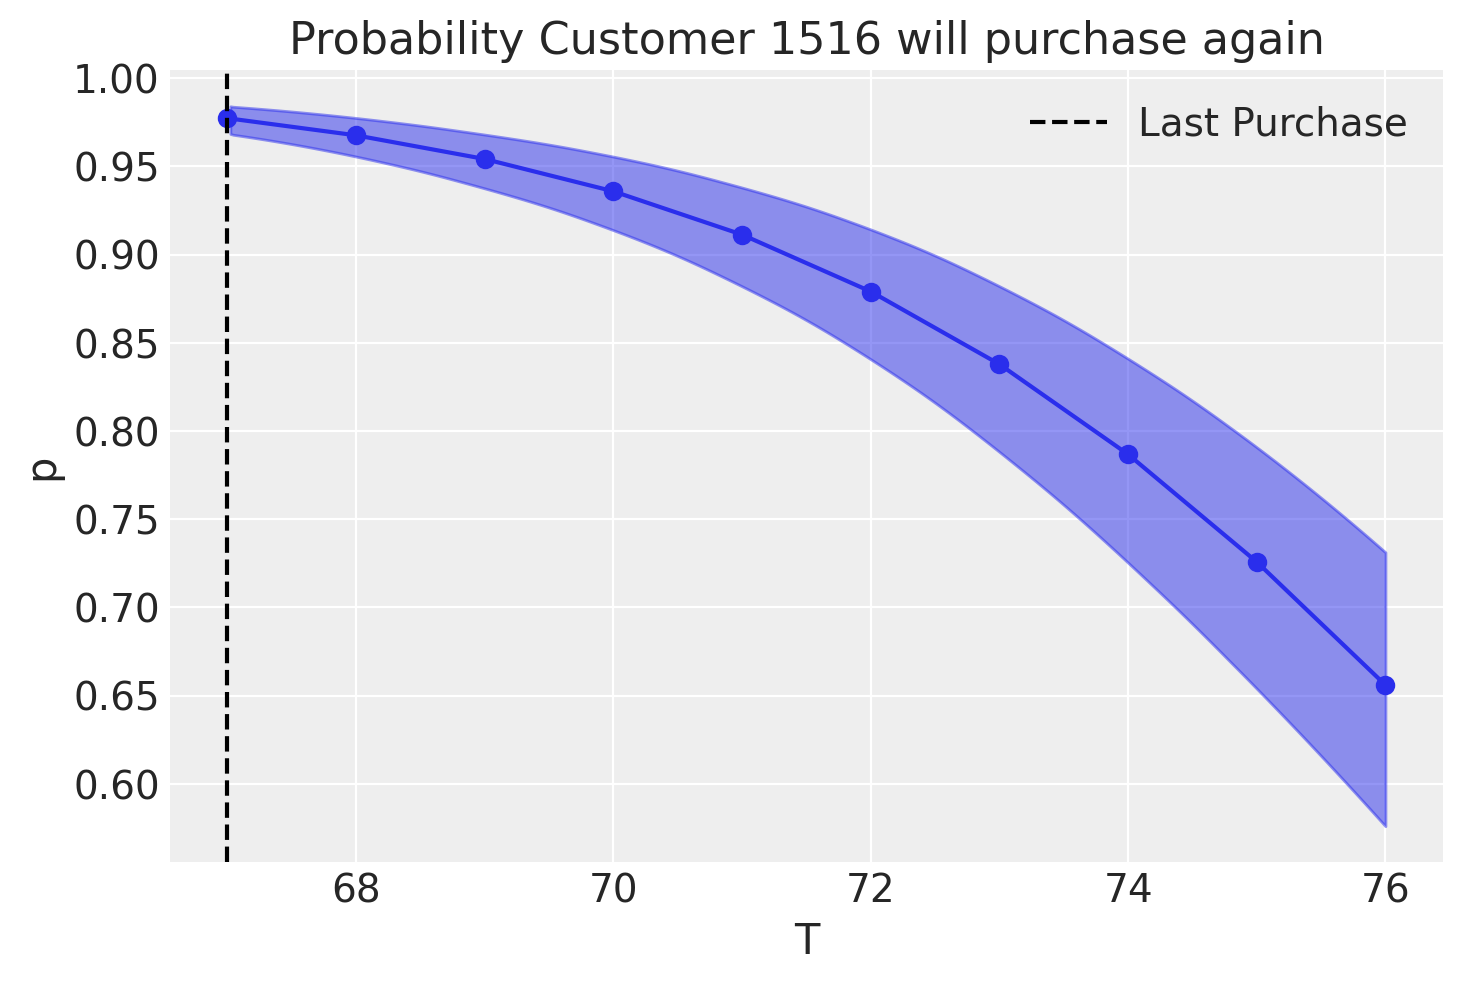

In [39]:
p_alive = bgm.expected_probability_alive(
    customer_id=customer_1516_history["ID"],
    frequency=customer_1516_history["frequency"],
    recency=customer_1516_history["recency"],
    T=customer_1516_history["T"],
)

az.plot_hdi(customer_1516_history["T"], p_alive, color="C0")
plt.plot(customer_1516_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(customer_1516_history["recency"].iloc[0], c="black", ls="--", label="Last Purchase")

plt.title("Probability Customer 1516 will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend();

## Estimating Customer Lifetime Value Using the Gamma-Gamma Model
Until now we’ve focused mainly on transaction frequencies and probabilities, but to estimate economic value we can use the Gamma-Gamma model.

The Gamma-Gamma model assumes at least 1 repeat transaction has been observed per customer. As such we filter out those with zero repeat purchases.

If computing the monetary value from your own data, note that it is the **mean** of a given customer’s value, not the sum. monetary_value can be used to represent profit, or revenue, or any value as long as it is consistently calculated for each customer.


In [40]:
nonzero_data = rfm_data.query("frequency>0")
nonzero_data

,customer_id,frequency,recency,T,monetary_value
0,1,3.0,49.0,78.0,23.723333
1,2,1.0,2.0,78.0,11.770000
5,6,14.0,76.0,78.0,76.503571
6,7,1.0,5.0,78.0,11.770000
7,8,1.0,61.0,78.0,26.760000
...,...,...,...,...,...
2351,2352,1.0,47.0,66.0,14.490000
2352,2353,2.0,53.0,66.0,19.775000
2353,2354,5.0,24.0,66.0,44.928000
2354,2355,1.0,44.0,66.0,24.600000



The Gamma-Gamma model relies upon the important assumption there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation is less than 0.3:

In [41]:
nonzero_data[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.052819
frequency,0.052819,1.000000


The Gamma-Gamma model takes in a ‘data’ parameter, a pandas DataFrame with 3 columns representing Customer ID, average spend of repeat purchases, and number of repeat purchase for that customer.

As with the BG/NBD model, these parameters are given HalfFlat priors which can be too diffuse for small datasets. For this example, we will use the default priors, but other priors can be specified just like with the BG/NBD example above.

In [42]:
dataset = pd.DataFrame({
    'customer_id': nonzero_data.index,
    'mean_transaction_value': nonzero_data["monetary_value"],
    'frequency': nonzero_data["frequency"],
})
gg = clv.GammaGammaModel(
    data = dataset
)
gg.build_model()
gg

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [43]:
gg.fit(fit_method="map");
gg.fit_summary()

Output()

p     4.785
q     3.882
v    22.653
Name: value, dtype: float64

In [44]:
gg.fit();
gg.fit_summary()

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,4.843,0.764,3.502,6.208,0.034,0.024,532.0,593.0,1.0
q,3.917,0.284,3.389,4.433,0.013,0.009,492.0,533.0,1.0
v,23.388,5.213,14.327,33.267,0.238,0.168,470.0,484.0,1.0


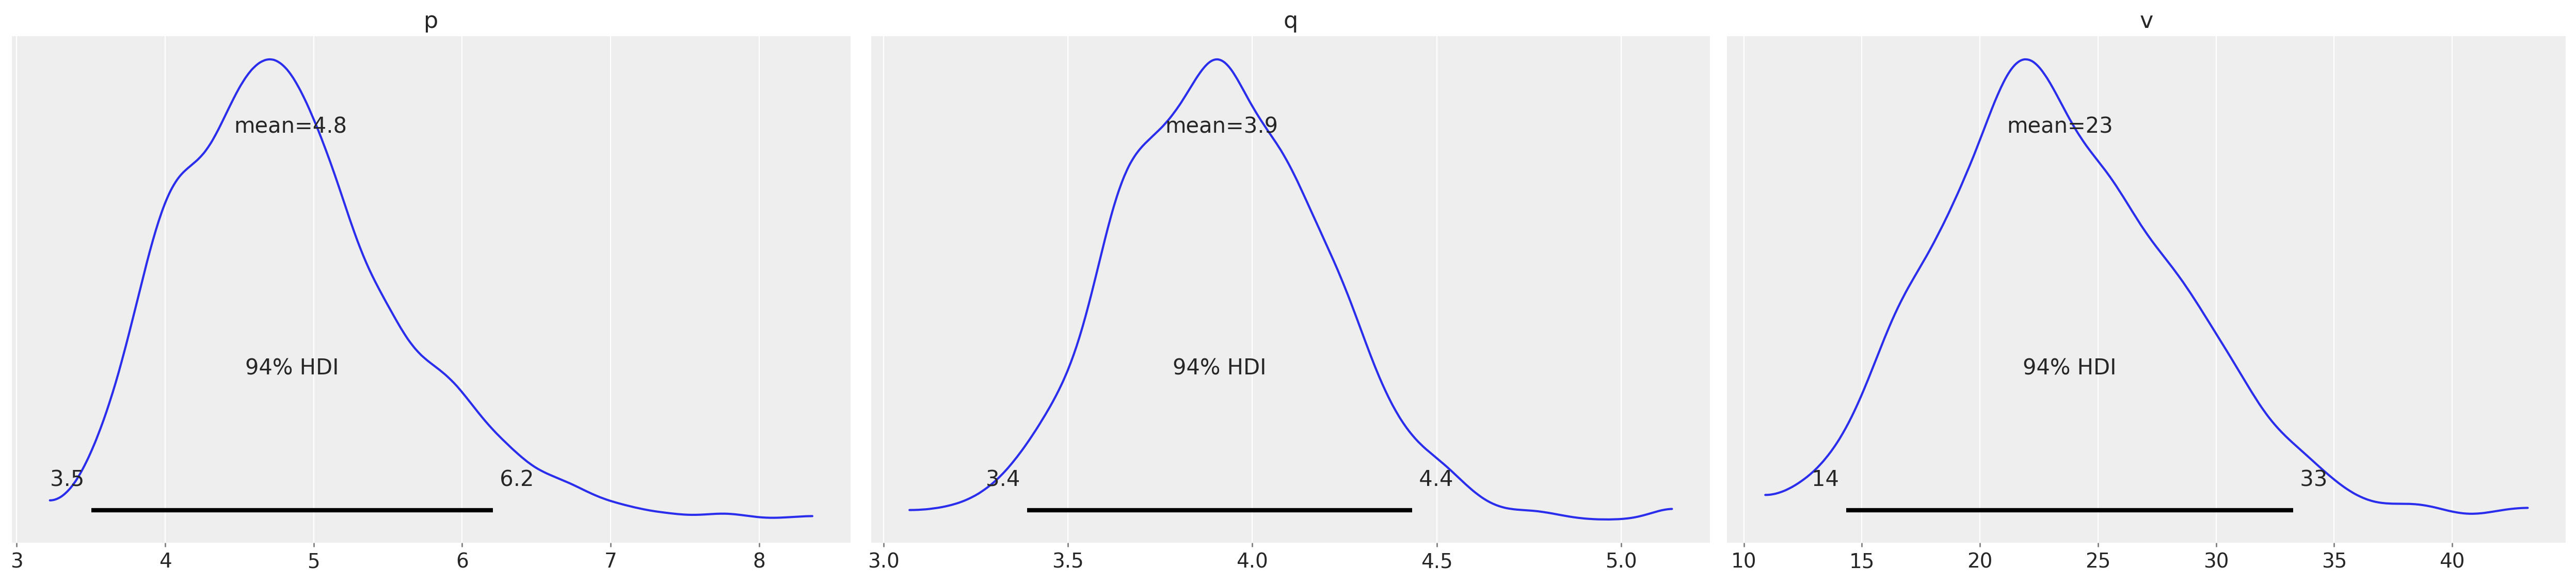

In [45]:
az.plot_posterior(gg.fit_result);

## Predicting spend value of customers
Having fit our model, we can now use it to predict the conditional, expected average lifetime value of our customers, including those with zero repeat purchases.

In [47]:
expected_spend = gg.expected_customer_spend(
    customer_id=rfm_data.index,
    mean_transaction_value=rfm_data["monetary_value"],
    frequency=rfm_data["frequency"],
)
summary = az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")
summary

,mean,sd,hdi_3%,hdi_97%
x[0],26.088,0.438,25.228,26.848
x[1],21.558,1.344,18.923,23.921
x[2],37.617,0.890,35.995,39.240
x[3],37.617,0.890,35.995,39.240
x[4],37.617,0.890,35.995,39.240
x[5],74.850,0.367,74.179,75.520
x[6],21.558,1.344,18.923,23.921
x[7],30.866,0.608,29.695,31.958
x[8],36.428,0.150,36.145,36.695
x[9],37.617,0.890,35.995,39.240


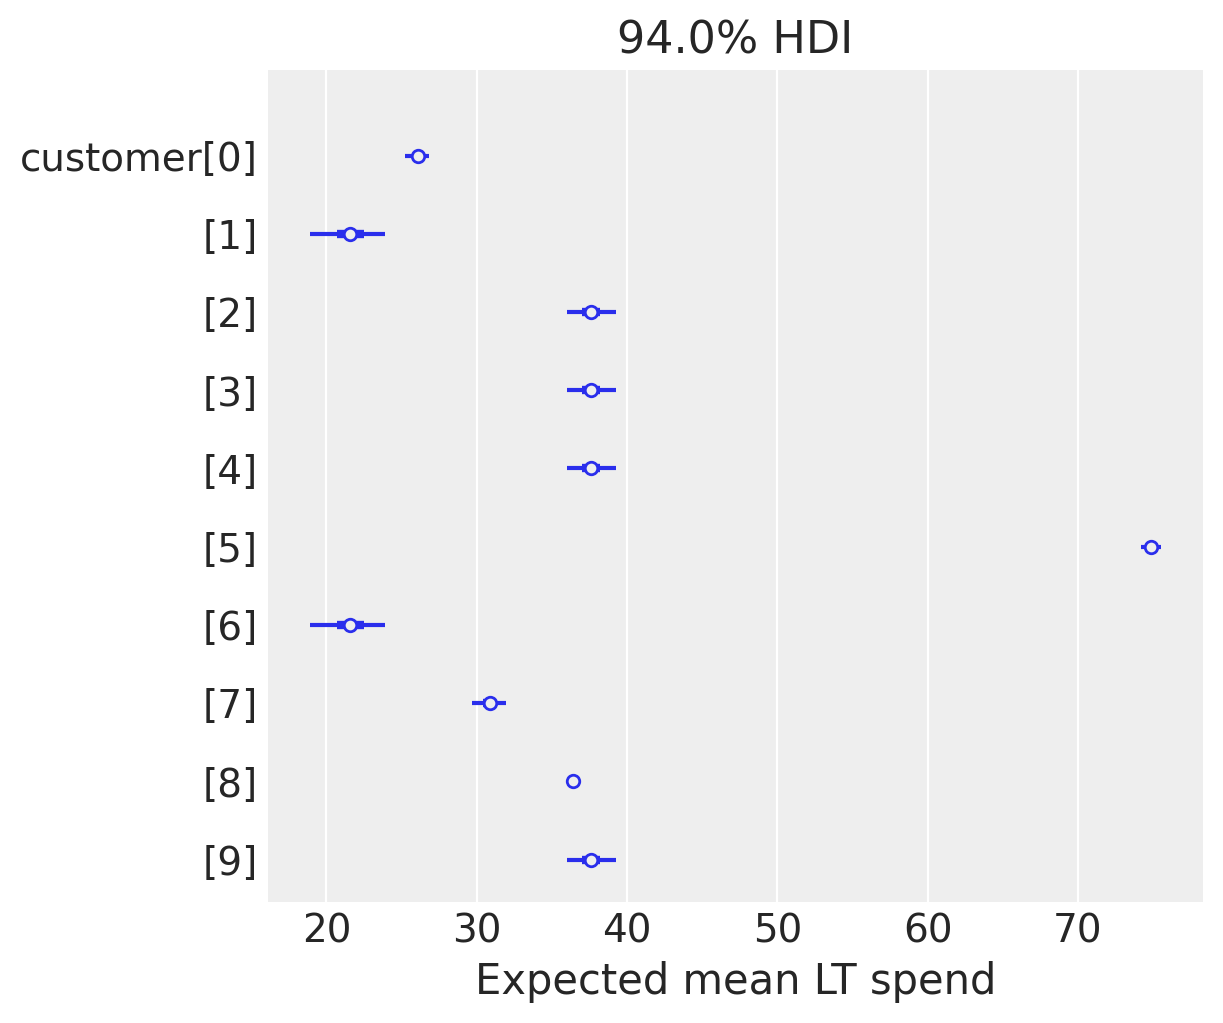

In [49]:
labeller = MapLabeller(var_name_map={"x": "customer"})
az.plot_forest(expected_spend.isel(customer_id=(range(10))), combined=True, labeller=labeller)
plt.xlabel("Expected mean LT spend"); #not LTV.

In [50]:
#We can also look at the average expected mean spend across all customers
az.summary(expected_spend.mean("customer_id"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,38.0,0.56,37.005,39.034


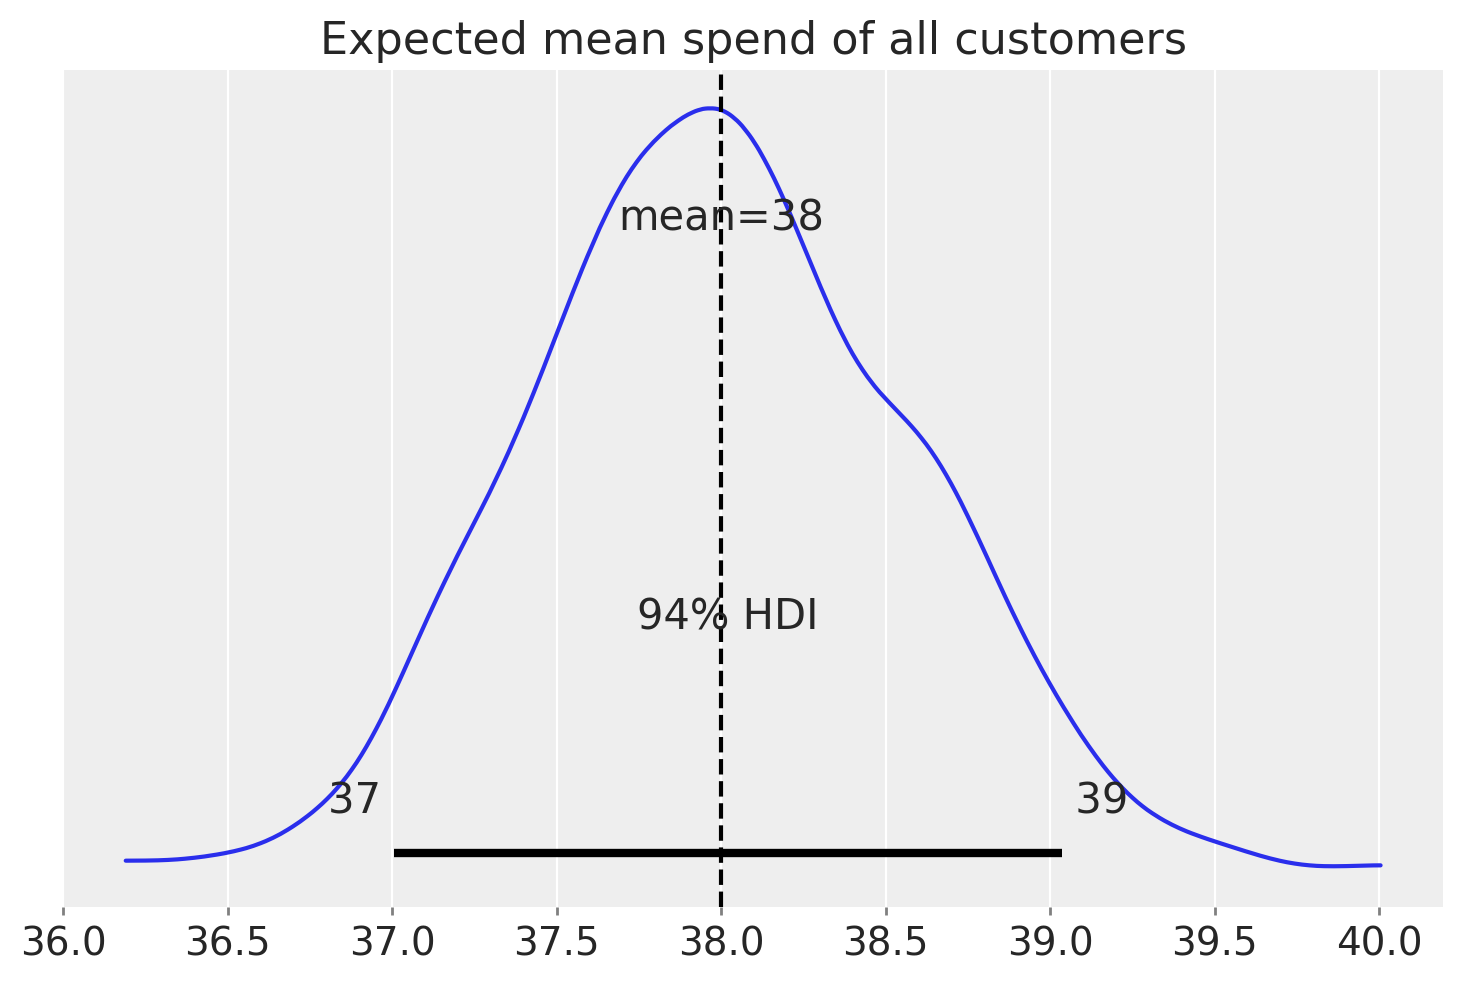

In [51]:
az.plot_posterior(expected_spend.mean("customer_id"))
plt.axvline(expected_spend.mean(), color="k", ls="--")
plt.title("Expected mean spend of all customers");

## Predicting spend value of a new customer

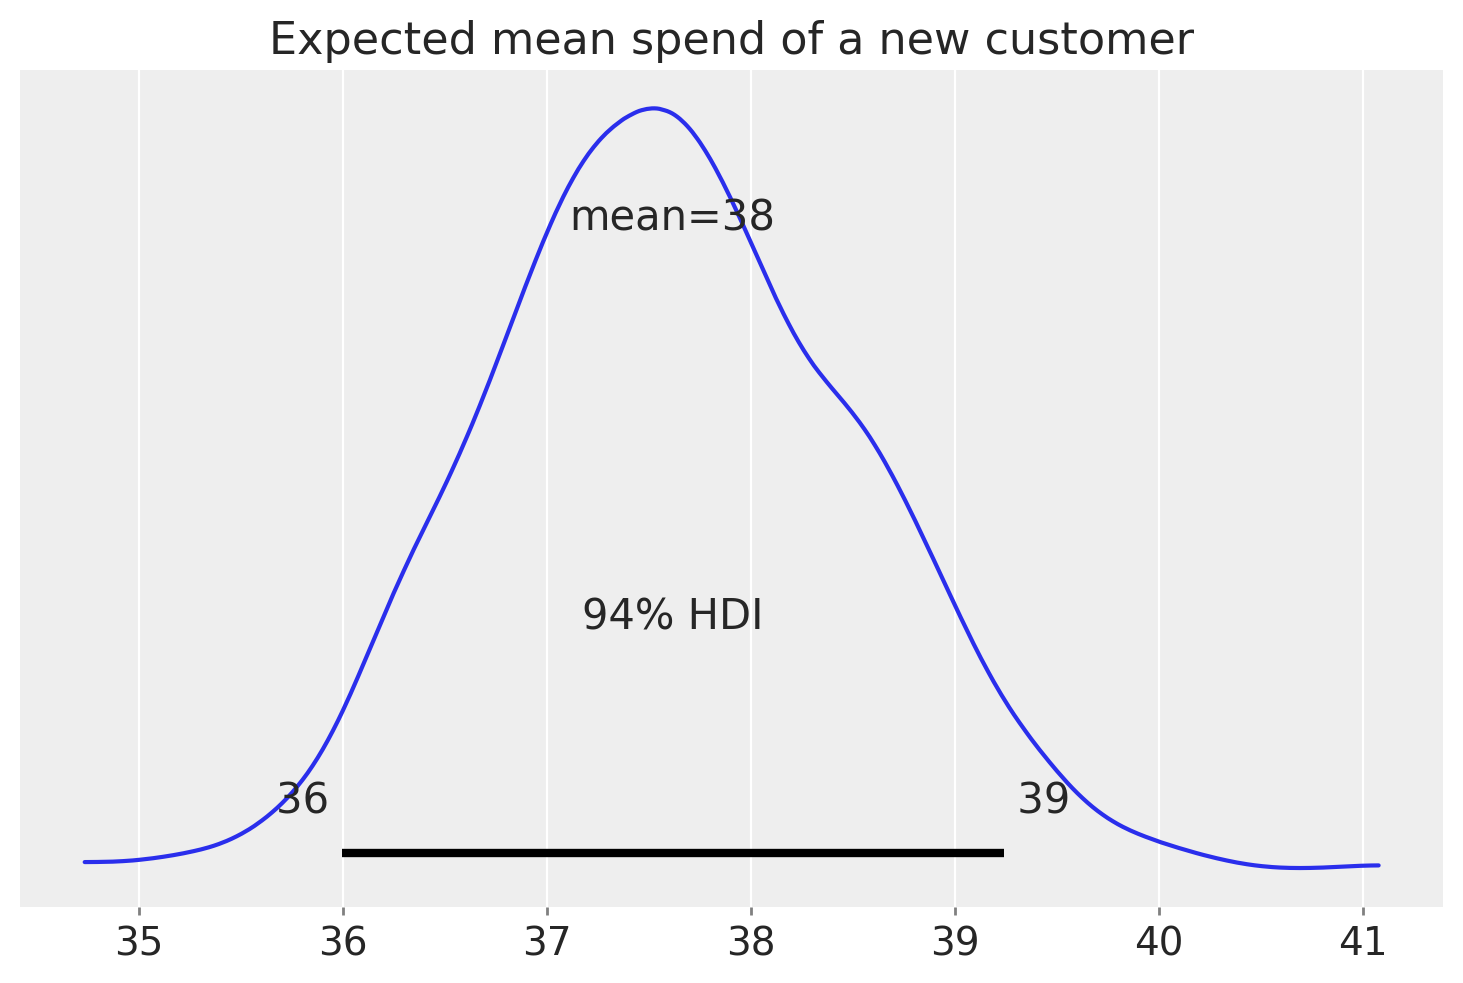

In [52]:
az.plot_posterior(
    gg.expected_new_customer_spend()
)
plt.title("Expected mean spend of a new customer");

## Estimating CLV
Finally, we can combine the GG with the BG/NBD model to obtain an estimate of the customer lifetime value. This relies on the Discounted cash flow model, adjusting for cost of capital:

In [53]:
clv_estimate = gg.expected_customer_lifetime_value(
    transaction_model=bgm,
    customer_id=rfm_data.index,
    mean_transaction_value=rfm_data["monetary_value"],
    frequency=rfm_data["frequency"],
    recency=rfm_data["recency"],
    T=rfm_data["T"],
    time=12, # months
    discount_rate=0.01, # monthly discount rate ~ 12.7% annually
    freq="W", # Our original data is in weeks
)
az.summary(clv_estimate.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[0],29.214,1.150,27.071,31.368
x[1],3.093,0.365,2.456,3.799
x[2],5.620,0.253,5.154,6.100
x[3],5.620,0.253,5.154,6.100
x[4],5.620,0.253,5.154,6.100
x[5],501.414,16.858,468.105,530.994
x[6],4.066,0.435,3.283,4.906
x[7],16.189,0.547,15.246,17.304
x[8],46.872,1.323,44.436,49.318
x[9],5.620,0.253,5.154,6.100


According to our models, customer[5] has a much higher expected CLV. There is also a large variability in this estimate that arises solely from uncertainty in the parameters of the BG/NBD and GG models.

In general, these models tend to induce a strong correlation between expected CLV and uncertainty. This modelling of uncertainty can be very useful when making marketing decisions.